In [1]:
# Images and Spatial Domain

In [261]:
import numpy as np
import matplotlib.pyplot as plt
import skimage

%matplotlib inline 

## plot settings
params = {
    'font.size' : 14.0,
    'figure.figsize': (20.0, 15.0),
    'figure.dpi' : 50
}
plt.rcParams.update(params)
plt.style.use('fivethirtyeight') #tableau-colorblind10 ggplot



import abc

#%run "../../../shared/utilz_includez.ipynb"

In [477]:
class MyImage():
    DOMAIN_SPATIAL = 1
    DOMAIN_FOURIER = 2
    
    def __init__(self, inputarray=None):
        self.imgarray = np.zeros((64,64)) if inputarray is None else inputarray
        
    def plot(self, domain=1, cmap=None):
        if domain == self.DOMAIN_SPATIAL:
            self.plot_graph(self.imgarray )
        elif domain == self.DOMAIN_FOURIER:
            self.plot_graph(self.fourier() )
        
    def fourier(self):
        return self.imgarray*3
    
    def plot_graph(self, img, cmap=None):
        plt.imshow(img, cmap=cmap)
        plt.title( f"Size: {self.imgarray.shape}")
        
    def hist(self, dbins=10, dranged=(0,255)):
        #binwidth to # bns
#         drange = ( max(np.min(self.imgarray),0), min(np.max(self.imgarray),10) )
        drng = (0,255)
        bins = int( np.abs( (drng[1]+1) )/dbins )
        plt.hist(self.imgarray.flatten(), bins=bins, range=dranged)
        plt.title(f"Bins: {bins}")
        
    def freedman_decois_bins(self, moden=False):
        iqr = np.subtract( *np.percentile(self.imgarray, [75, 25]) )
        n, r = self.imgarray.shape 
        N = (n*r) if moden is False else 256
        return int(np.round( (2 * iqr)/( (N)**(1/3)), 0))
    
    def binary(self):
        img = BinaryFilter.apply( self.imgarray )
        self.plot_graph(img, cmap='gray')
        return img 
        
class AFilter:     
    @staticmethod
    def pad_image(img, pr=2, pc=2):
        ## TODO: update padding with kern size 
        n, r = img.shape
        base = np.zeros( (n+pr, r+pc))
        base[ 1:-pr//2, 1:-pc//2] = img        
        return base
    
    @staticmethod
    def convolve(img, kern):
        ## 1. 180 flip kern << mirror in 2-D not transpose. If you don't flip then it is a cross-correlation and not convolution.  
        ## 2. product sum 
        ## 3. return center as point on new image 
        ## - numpy.convolve does all the below in one call but hey, we in learning mode here so sassying it out
        
#         if True:
#             return np.convolve(img, kern)
        # flip 180 degrees 
        kern_flipped = np.flip(kern, 1)
        def flip_180(kern):
            ## Transpose --> reverse elements column wise --> transpose again --> reverse column wise again 
            ## OR a 180 rotation linear transform ???
            transform_matrix = np.zeros( kern.shape ).fill_diagonal(-1)
            return kern @ transform_matrix
        
        def kern_reduce(phood):            
            psum = np.sum(np.multiply(kern_flipped, phood))            
            return psum 
        
        img_r, img_c = img.shape 
        k_r, k_c = kern.shape 
        
        output_image = np.zeros( img.shape )
        
        for i in range(img_r):            
            mr = (i+k_r)
            for j in range(img_c):
                mc = (j+k_c)
                ri, ci = (img_r - (i+k_r)), (img_c - (j+k_c))
                phood = img[ i: mr, j:mc]
                output_image[i,j] = kern_reduce(phood)
                
                ## break if boundary
                if mc == img_c:
                    break                    
            ## break if boundary
            if mr == img_r:
                break
                
    @abc.abstractmethod
    def apply(img, with_padding=False):
        raise NotImplemented 
    
    
class BinaryFilter(AFilter):
    @staticmethod
    def basic_thresh(img):
        bmax = np.max(img)
        bmean = np.mean(img)
        bmedian = np.median(img)        
        thresh =  np.abs((bmedian-bmax)/(bmedian-bmax))*bmean 
        return thresh
    
    @staticmethod
    def apply(img, with_padding=False, kern=None):
        # 1. prepare image by padding borders
        # 2. run kernel specific convolve
        # 3. 
        img2 = img.copy()
        if with_padding:
            return BinaryFilter.binary_mask( AFilter.pad_image(img2) ) 
        else:
            return BinaryFilter.binary_mask( img2 ) 
        
    @staticmethod
    def binary_mask(img ):             
        thresh = BinaryFilter.basic_thresh(img)
        #mask = np.ma.MaskedArray(img >= thresh, img)  
        img[ img >= thresh ] = 255
        img[ img < thresh ] = 0
        return img

class RandFilter(AFilter):
    @staticmethod
    def apply(img, with_padding=False, kern=None):
        kern = np.ones( (5, 5))/360
        kern[ 1:-1, 1:-1 ] = 100
        kr, kc = kern.shape
        pr, pc = int((kr-1)//2), int((kc-1)//2)
        AFilter.convolve( AFilter.pad_image(img.copy(), pr, pc), kern ) 

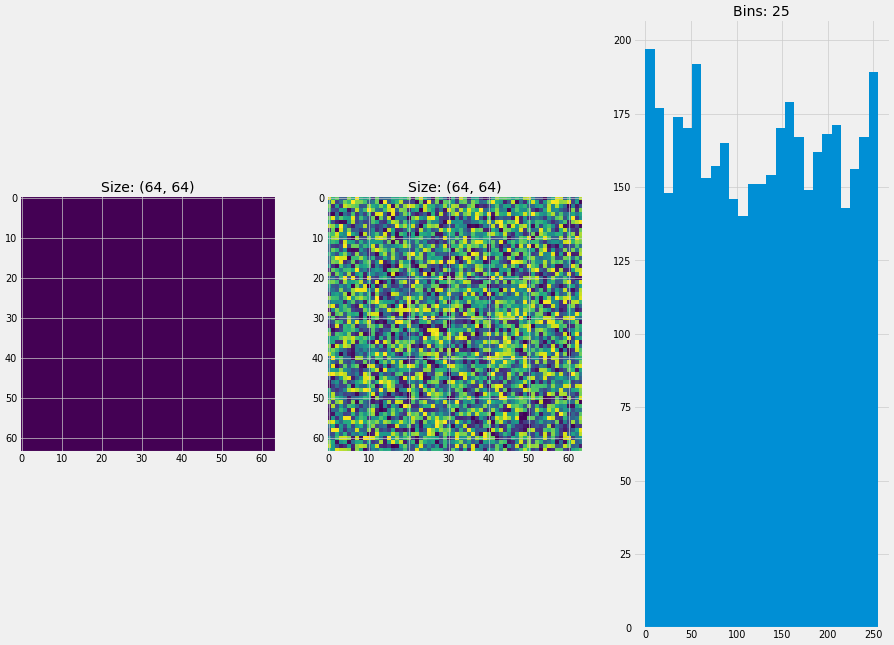

In [446]:
img = MyImage()
plt.subplot(1, 3, 1)
img.plot()
img = MyImage( np.random.randint(0,255, 64*64).reshape( (-1, 64)) )
plt.subplot(1, 3, 2)
img.plot(2)
plt.subplot(1, 3, 3)
img.hist(); 

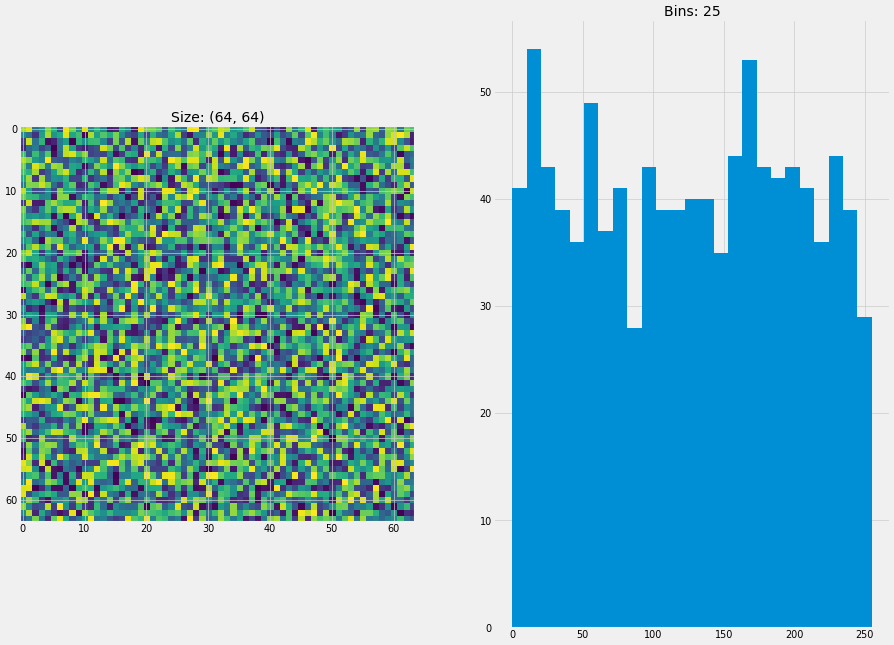

In [447]:
img = MyImage( np.random.rand(64, 64)*1000 )
plt.subplot(1, 2, 1)
img.plot()
plt.subplot(1, 2, 2)
img.hist(); 

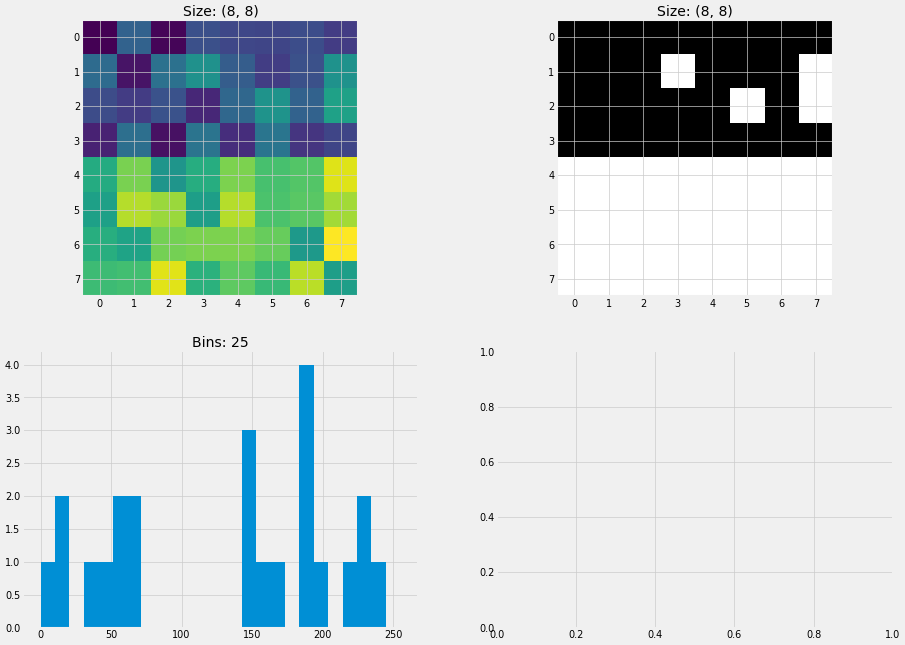

In [448]:
img2 = MyImage(np.genfromtxt("../../data/hw1.csv"))
plt.subplot(2, 2, 1)
img2.plot()
plt.subplot(2, 2, 2)
img2.binary()

## histogram 
plt.subplot(2, 2, 3)
img2.hist(); 
### Using Matplotlib 
plt.subplot(2,2,4)
np.histogram( img2.imgarray, img2.freedman_decois_bins()); 

[1, 5, 10, 20, 30, 70, 167, 105]


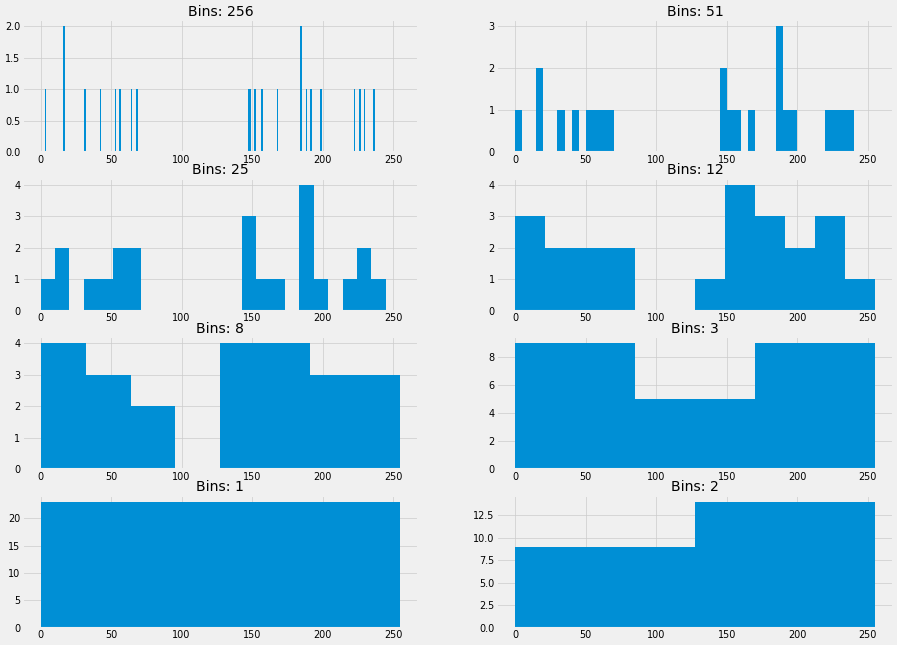

In [449]:
axns = [1, 5, 10, 20, 30, 70, img2.freedman_decois_bins(), img2.freedman_decois_bins(moden=True)]
nc = 2
nr = len(axns) // nc 
nr = nr+1 if len(axns) % nc != 0 else nr 

print( axns)

for i, axn in enumerate(axns):
    plt.subplot(nr, nc, i+1)
    img2.hist(dbins=axn)
    #print( f"{256/axn}")
    
plt.show(); 

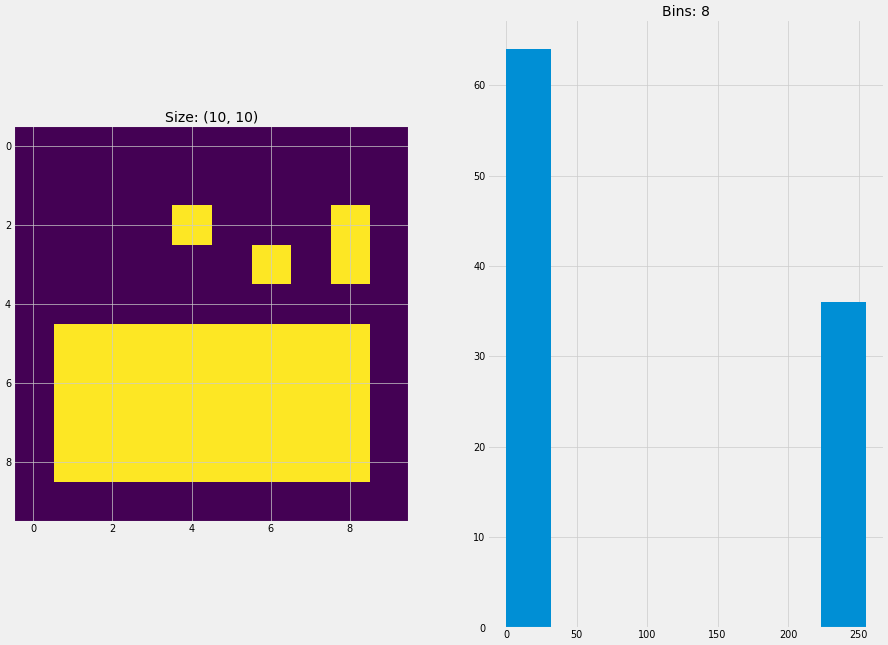

In [450]:
img_binary = BinaryFilter.apply(img2.imgarray, True)
img = MyImage(img_binary)
# print( img_binary )

plt.subplot(1, 2, 1)
img.plot()
plt.subplot(1, 2, 2)
img.hist(30); 


In [461]:
# img_rand = RandFilter.apply(img2.imgarray, True)

# #img_rand  = np.convolve( img2.imgarray, np.ones((5,5))*.75 )
# img = MyImage(img_rand)
# # print( img_binary )

# plt.subplot(1, 2, 1)
# img.plot()
# plt.subplot(1, 2, 2)
# img.hist(30); 


4 2
1 2
3 4
5 6
7 8


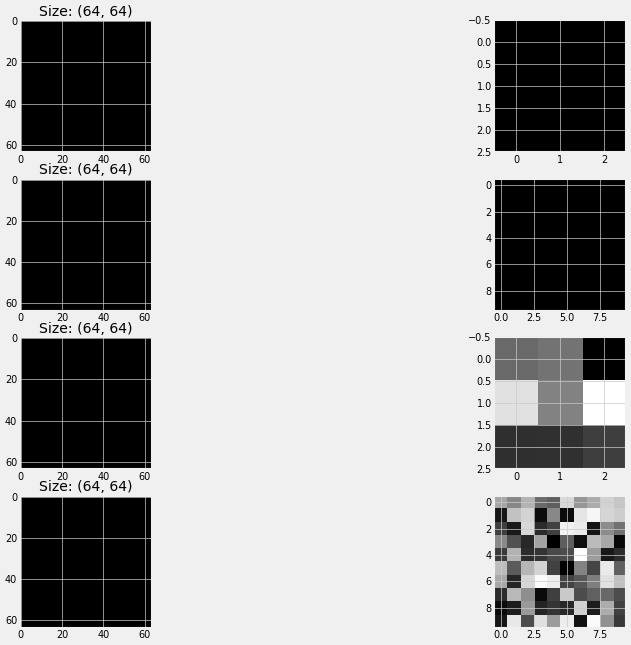

In [513]:
axns_a = [ (np.ones, 0), (np.random.rand,1)]
axns_b = [(3,3), (10,10) ] #(5,5), (7,7), 
plots = 2 
nc = 2
nr = len(axns_a) * len(axns_b)

print(nr, nc)

somecounter = 0
for i, axn in enumerate(axns_a):
    for j, ksize in enumerate( axns_b ):        
        kern = axn[0](ksize)*((i+1)*(j+1)*(-100 * j%2)) if axn[1] == 0 else axn[0](*ksize)
        img = MyImage( RandFilter.apply( img2.imgarray, kern=kern ) ) 
        
        ap = somecounter*2         
        p1 = ap + 1
        p2 = p1 + 1
        print(p1, p2)
        
        plt.subplot(nr, nc, p1 )
        img.binary()
        plt.subplot(nr, nc, p2)
        #img.hist(30)
        plt.imshow( np.flip(kern), cmap='gray' )
        
        somecounter += 1       
        
        
plt.show(); 

In [512]:
def flip_180(ent):    
    
    ## Transpose --> reverse elements column wise 
    ##     --> transpose again --> reverse column wise again
    r,c = ent.shape 
    d = ent.T
    e = np.zeros( d.shape , int)
    for j in range(c):
        e[j] = d[j][::-1]
    # second time 
    d = e.T
    e = np.zeros( d.shape , int)
    for j in range(c):
        e[j] = d[j][::-1]
    return e

    
    ## OR a 180 rotation linear transform ???
#     transform_matrix = np.zeros( a.shape , int)
#     np.fill_diagonal( transform_matrix, -1)
#     return ent@transform_matrix 

a = np.array([1,2,3,4,5,6,7,8,9]).reshape((-1,3))
a

print("\n----\nnp.flip === 0")
np.flip(a, 0)

print("\n----\nnp.flip === 1")
np.flip(a, )

print("create diagonal for 180 transform matrix")
b = np.zeros( a.shape, int )
np.fill_diagonal( b, -1)
b

print("T-->reverse-->T--reverse")
d = a.T.flatten()[::-1] 
d = d.reshape(*a.shape)
#d.T
r,c = d.shape 
e = np.zeros( d.shape , int)
for j in range(c):
    e[j] = d[j][::-1]
e.T


print("T-->reverse-->T--reverse ===== 2")
r,c = a.shape 
d = a.T
e = np.zeros( d.shape , int)
for j in range(c):
    e[j] = d[j][::-1]
# second time 
d = e.T
e = np.zeros( d.shape , int)
for j in range(c):
    e[j] = d[j][::-1]
e


print("flip_180")
flip_180(a)

array([[1, 2, 3],
       [4, 5, 6],
       [7, 8, 9]])


----
np.flip === 0


array([[7, 8, 9],
       [4, 5, 6],
       [1, 2, 3]])


----
np.flip === 1


array([[9, 8, 7],
       [6, 5, 4],
       [3, 2, 1]])

create diagonal for 180 transform matrix


array([[-1,  0,  0],
       [ 0, -1,  0],
       [ 0,  0, -1]])

T-->reverse-->T--reverse


array([[3, 2, 1],
       [6, 5, 4],
       [9, 8, 7]])

T-->reverse-->T--reverse ===== 2


array([[9, 8, 7],
       [6, 5, 4],
       [3, 2, 1]])

flip_180


array([[9, 8, 7],
       [6, 5, 4],
       [3, 2, 1]])

# Fourier Transform 
**Fourier Transform**

**Inverse Fourier Transform**

**Why**
- solving partial differential equations
- Laplace transform as another integral transform 
- Fourier transforms appear when limits are applied to fourier series 
- Fourier transform can handle non-periodic functions, which fourier series cannot do 
- 